# Paramagnetismo 

In [3]:
import utils
import numpy as np
import matplotlib.pyplot as plt

### Magnetización promedio

$$
\begin{equation}
    <M> = \frac{1}{MCS_{max} - t_o} \sum_{t_o + 1}^{MCS_{max}} M_k
\end{equation}
$$

Donde:

$$
\begin{equation}
    M_k = \sum_{i=1}^{N} \sigma_i
\end{equation}
$$


In [4]:
# numero cuantico m, m = -J,-J+1,-J+2,...,J-1,J
m_numbers = lambda J: np.arange(-J, J+1)


def build_system(SIZE, m):
    """Microestado inicial aleatorio"""
    spin =  np.random.choice(m, size=(SIZE, SIZE))
    return spin


def metropolis(config,m,J,B,T):

    """ 
    Algoritmo de metrópolis 
    config = Configuración del sistema
    m = número cuántico m
    J = Parametro de intercambio
    B = Campo magnetico externo
    T = Temperatura
    """

    L = len(config) # Tamaño 
    for i in range(L):
        for j in range(L):

            conf_i = config[i, j] 

            # sitios vecinos
            conf_j = config[(i+1)%L, j] + config[i, (j+1)%L] + config[(i-1)%L, j] + config[i, (j-1)%L] 
            
            # Energia inicial del sitio
            Ei = -J*np.dot(conf_i,conf_j) - conf_i*B 

            # Invertir el espín del sitio seleccionado
            conf_trial = config[i, j] * -1

            # Calculo de Energia luego de perturbar el vector a evaluar
            Ef = -J*np.dot(conf_trial,conf_j) - conf_trial*B 
            
            # Diferencia entre energia luego de perturbar el sitio y energia inicial
            Delta_E = Ef - Ei 

            # Criterio de montecarlo, si minimiza la energia permitir la perturbacion
            if Delta_E <= 0 or np.random.rand() <= np.exp(-Delta_E/T): 
                conf_i = conf_trial

            # almacena la configuracion que cumple la condición
            config[i, j] = conf_i 

    return config


def montecarlo_step(config,m,J,B,T):

    """
    Función que permite implementar el algoritmo de montecarlo
    tal que se calcule la magnetización promedio
    config = Configuracion del sistema.
    m = Lista de numero cuantico m
    J = Parametro de intercambio
    B = Campo magnetico externo
    T = Temperatura
    """

    # número máximo de pasos de montecarlo
    MCSmax = 100 

    # Magnetización
    Magnetiz = 0

    # criterio de estabilidad en la medida
    to = int(MCSmax/2)

    # evolución el sistema
    for mcs in range(MCSmax):
        config = metropolis(config,m,J,B,T) 
        
        if mcs > to: 
            # calculo de magnetizacion
            Magnetiz += np.sum(config) 
    
    # Magnetizacion promedio
    Magnetiz = Magnetiz/(MCSmax-to) 
    return Magnetiz



def main(s,J,B,T,SIZE=100):
    """
    Función pincipal que ejecuta el algoritmo de Metropolis
    para distintos valores de campo magnético externo
    Retorna un array de la magnetización promedio
    s = spin
    J = Parametro de intercambio
    B = Campo magnético externo
    T = Temperatura
    """

    m = m_numbers(s)

    # Configuracion inicial    
    config = build_system(SIZE, m) 
    
    # Magnetizacion
    M = [] 

    # recorre los valores del campo magnetico
    for i,b in enumerate(B): 
        # barra de progreso
        utils.progressBar(i+1, len(B))

        # evoluciona el sistema 
        Magnetiz = montecarlo_step(config, m, J, b, T) 
        M.append(Magnetiz)
        
    
    return np.array(M) # retorna los resultados.

## Paramagneto $J=0$

### Ising

$$
\begin{equation}
    \mathcal{H_{ising}} = -J \sum_{<i,j>} S_i S_j - H \sum_{i=1} S_i
\end{equation}
$$

Donde $S=1/2$, $x=\frac{\mu H}{k_B T}$

$$
\begin{equation}
    <M> = \mu N tanh(x)
\end{equation}
$$

In [5]:
def isingModel(x):
    return np.tanh(x) 

In [33]:
def ParamgIsingOrBrillouin(itype):

    """
    Ejecuta el algoritmo principal dependiendo del 
    modelo (Ising o Brillouin) para 3 valores de temperatura 
    y guarda los resultados.
    """

    SIZE=100
    

    # Isotermas T1, T2, T3
    for T in [10, 100, 1000]:
        
        B=np.linspace(-25,25,100)

        if itype=="ising":
            M = main(s=1/2, J=0, B=B, T=T, SIZE=SIZE)
            utils.save_lists_as_columns(f"{itype}_MvsH_T_{T}.txt", B, M)

        if itype=="brillouin":
            M = main(s=3/2, J=0, B=B, T=T, SIZE=SIZE)
            utils.save_lists_as_columns(f"{itype}_MvsH_T_{T}.txt", B, M)
               
    

In [10]:
ParamgIsingOrBrillouin(itype="ising")

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


In [105]:
def GraphIsingOrBrillouin(itype_graph, itype, SIZE, s):

    """
    Realiza las gráficas de magnetización promedio vs. campo 
    magnético externo o campo magnético externo dividido por la temperatura.
    Depende de si es Ising o Brillouin, carga los datos y compara con el modelo
    itype_graph =  tipo de gráfica
    itype = modelo
    SIZE = tamaño grid
    s = spin
    """
    
    if itype_graph == "MH":
        for i, t in enumerate([10, 100, 1000]):

            # lee los resultados generados con el MC
            data = np.loadtxt(f"{itype}_MvsH_T_{t}.txt").T

            # grafica
            plt.plot(data[0], data[1]/(SIZE*SIZE), '.', alpha=0.5,label= f"T={t}")
            
        plt.xlabel("H")

    if itype_graph == "MH_T":
        
        for i, t in enumerate([10, 100, 1000]):

            # lee los resultados generados con el MC
            data = np.loadtxt(f"{itype}_MvsH_T_{t}.txt").T
            B = data[0]
            
            # dependiendo si es modelo de "Ising" o "Brillouin"
            if itype == "ising": 
                theoric = isingModel(x=B*s/t)
                magnet = data[1]/(SIZE*SIZE*s)
            if itype == "brillouin": 
                theoric = brillouinModel(x=B*s/t, S=s)
                magnet = data[1]/(SIZE*SIZE)

            # grafica
            label=""
            if i==2: label= "Modelo teórico"
            plt.plot(B/t, magnet, '.', label= f"T={t}", alpha=0.5)       
            plt.plot(B/t, theoric, color="black", label=label)

        plt.xlabel("H/T")
            
    plt.legend()
    plt.grid()
    plt.ylabel("<M>/N")
    plt.savefig(f'plots/paramag_{itype}_{itype_graph}.png')



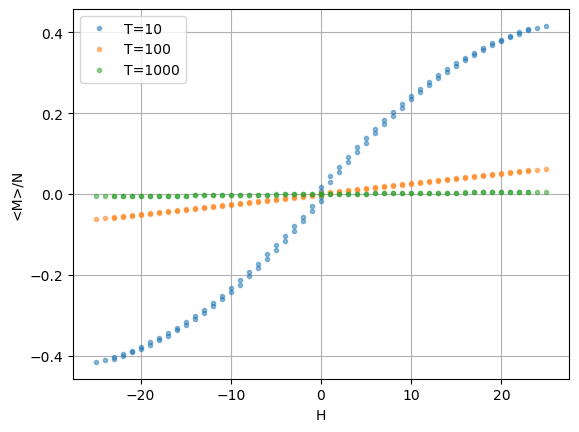

In [106]:
GraphIsingOrBrillouin(itype_graph="MH", itype="ising", SIZE=100, s=1/2)

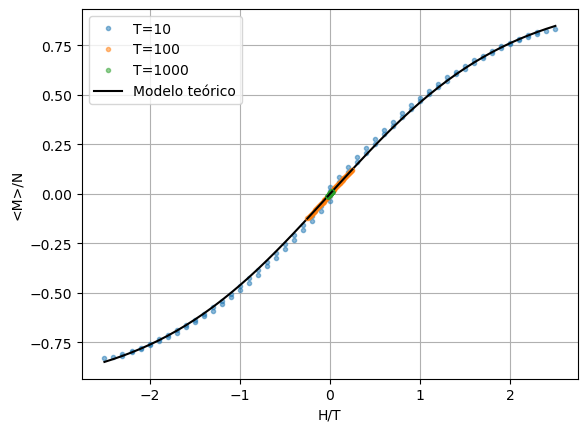

In [107]:
GraphIsingOrBrillouin(itype_graph="MH_T", itype="ising", SIZE=100, s=1/2)

### Brillouin
Donde $S=3/2$, $x=\frac{\mu H}{k_B T}$

$$
\begin{equation}
    B_J(x) = \frac{2J+1}{2J} coth\left(\frac{2J+1}{2} x \right) - \frac{1}{2J} coth\left(\frac{1}{2} x\right)
\end{equation}
$$

$$
\begin{equation}
    <M> = g \mu_B J N B_J(x) 
\end{equation}
$$

In [99]:
def brillouinModel(x,S):
    coth = lambda x: 1 / np.tanh(x)
    C = ((2*S + 1) / 2)
    return  (1/S)*(C*coth(C*x) - (1/2)*coth(x/2))

In [21]:
ParamgIsingOrBrillouin(itype="brillouin")

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


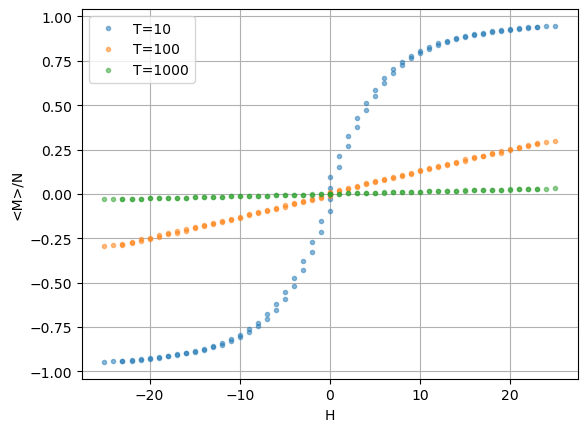

In [110]:
GraphIsingOrBrillouin(itype_graph="MH", itype="brillouin", SIZE=100, s=3/2)

/var/folders/8h/p03rjs6x5378pln2gkncg9fc0000gn/T/ipykernel_1225/872526300.py:2: RuntimeWarning: divide by zero encountered in divide
  coth = lambda x: 1 / np.tanh(x)
/var/folders/8h/p03rjs6x5378pln2gkncg9fc0000gn/T/ipykernel_1225/872526300.py:4: RuntimeWarning: invalid value encountered in subtract
  return  (1/S)*(C*coth(C*x) - (1/2)*coth(x/2))


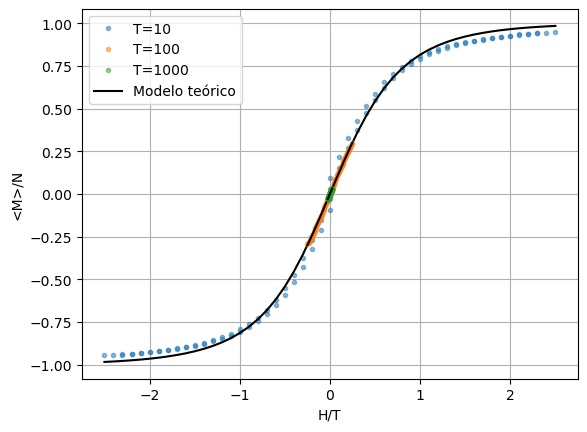

In [108]:
GraphIsingOrBrillouin(itype_graph="MH_T", itype="brillouin", SIZE=100, s=3/2)